## Моделирование молекулярной динамики

   - Система: ГЦК решётка $7\times7\times7$ частиц;
   - Постоянная решётки: $a = 1.75~\sigma $;
   - Потенциал взаимодействия: Леннард-Джонс;
   - Начальная температура: $T_i = 1.0~\varepsilon / k_B$;
   - Конечная температура: $T_f = 10^{-10}~\varepsilon / k_B$;
   - Скорость охлаждения: $v_T = 0.001~\varepsilon / k_B\tau$;
   - Баростат: Velocity Scaling;
   - Толщина сферического слоя (список Верле): $\Delta r_s = 0.3~\sigma $;
   - Временной шаг: $\Delta t = 0.005~\tau$;
   - Число шагов для охлаждения: 40000;
   - Функция радиального распределения, среднеквадратичное смещение и коэффициенты самодиффузии рассчитывалась через каждые 2500 шагов;
   - Подсчёт состоял из 2499 шагов: 500 на уравновешивание системы при фиксированной температуре и 1999 на усреднение по ансамблям (к первому ансамблю относятся шаги с 1 по 1000 шаг, ко второму - с 2 по 1001 и т.д.);
   - Функция радиального распределения вычислялась как среднее по времени за первые 1000 шагов;

#### Импорт необходимых библиотек

In [1]:
from copy import deepcopy
from datetime import datetime
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

#### Настройки рисунков

In [2]:
plt.style.use('seaborn')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['figure.figsize'] = [i / 2.54 for i in (15, 15)]
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['mathtext.it'] = 'Times New Roman'
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['axes.labelsize'] = 14

#### Путь к файлам с данными

In [3]:
BASE_DIRECTORY = os.path.dirname(os.getcwd())
PATH_TO_ALL_DATA = os.path.join(BASE_DIRECTORY, 'data')
PATH_TO_ALL_PLOTS = os.path.join(BASE_DIRECTORY, 'plots')
CURRENT_DATA = '2021-02-09_slow'

PATH_TO_CURRENT_DATA = os.path.join(PATH_TO_ALL_DATA, CURRENT_DATA)
PATH_TO_CURRENT_PLOTS = os.path.join(PATH_TO_ALL_PLOTS, CURRENT_DATA)

try:
    os.mkdir(PATH_TO_CURRENT_PLOTS)
except FileExistsError:
    pass

In [4]:
rdf_filename = os.path.join(PATH_TO_CURRENT_DATA, 'rdf_T_')
transport_filename = os.path.join(PATH_TO_CURRENT_DATA, 'transport_T_')
parameters_filename = os.path.join(PATH_TO_CURRENT_DATA, 'system_parameters.csv')

In [5]:
plot_filename_postfix = 'slow_cooling'

In [6]:
def get_merged_data(old_data, data_filename_prefix, merge_column, old_column_name, temperature, columns = None):
    df = pd.read_csv(
        f'{data_filename_prefix}{temperature:.5f}.csv',
        sep=';',
    )
    if columns is not None:
        df = df[columns]
    merged_data = old_data.merge(
        right=df,
        how='outer',
        on=merge_column,
    )
    merged_data = merged_data.rename(columns={old_column_name: f'{temperature:.5f}'})
    return merged_data

In [7]:
def save_plot(filename):
    plt.savefig(
        os.path.join(PATH_TO_CURRENT_PLOTS, filename)
    )

#### Температуры, для которых была подчитана функция радиального распределения

In [8]:
file_creation_times = []
temperatures = []
for filename in os.listdir(PATH_TO_CURRENT_DATA):
    if filename.startswith('rdf'):
        file_creation_times.append((filename, os.path.getmtime(os.path.join(PATH_TO_CURRENT_DATA, filename))))

for item in sorted(file_creation_times, key=lambda x: x[1]):
    temperatures.append(float(item[0][6:13]))
    
temperatures = tuple(temperatures)

colors = (
    'black',
    'red',
    'green',
    'blue',
    'cyan',
    'magenta',
    'purple',
    'orange',
    'olive',
    'yellow',
    'brown',
    'pink',
    'gray',
    'lime',
    'slateblue',
    'crimson',
    'darkviolet',
    'sienna',
    'coral',
)

temperatures

(0.99962,
 0.99563,
 0.98916,
 0.97571,
 0.96021,
 0.95027,
 0.93679,
 0.92683,
 0.91272,
 0.904,
 0.88363,
 0.87196,
 0.86302,
 0.84929,
 0.83708,
 0.82435,
 0.81386,
 0.79686)

#### Извлечение значений функции радиального распределения из файлов

In [9]:
rdf_data = pd.DataFrame(columns=['radius'])
msd_data = pd.DataFrame(columns=['time'])
vel_autocor_data = pd.DataFrame(columns=['time'])
einstein_diffusion_data = pd.DataFrame(columns=['time'])
green_kubo_diffusion_data = pd.DataFrame(columns=['time'])

for temperature in temperatures:
    rdf_data = get_merged_data(
        old_data=rdf_data,
        data_filename_prefix=rdf_filename,
        merge_column='radius',
        old_column_name='rdf',
        temperature=temperature,
    )
    transport_kwargs = {
        'data_filename_prefix': transport_filename,
        'merge_column': 'time',
        'temperature': temperature,
    }
    msd_data = get_merged_data(
        old_data=msd_data,
        old_column_name='msd',
        columns=['time', 'msd'],
        **transport_kwargs,
    )
    vel_autocor_data = get_merged_data(
        old_data=msd_data,
        old_column_name='velocity_autocorrelation',
        columns=['time', 'velocity_autocorrelation'],
        **transport_kwargs,
    )
    einstein_diffusion_data = get_merged_data(
        old_data=msd_data,
        old_column_name='einstein_diffusion',
        columns=['time', 'einstein_diffusion'],
        **transport_kwargs,
    )
    green_kubo_diffusion_data = get_merged_data(
        old_data=msd_data,
        old_column_name='green_kubo_diffusion',
        columns=['time', 'green_kubo_diffusion'],
        **transport_kwargs,
    )

#### Графики функций радиального распределения $g(\textbf{r})$ при различных температурах

$$g(\textbf{r})=\dfrac{V}{N^2}\left<\sum_{i}{\sum_{j\ne i}{\delta(\textbf{r}-\textbf{r}_{ij})}}\right>$$

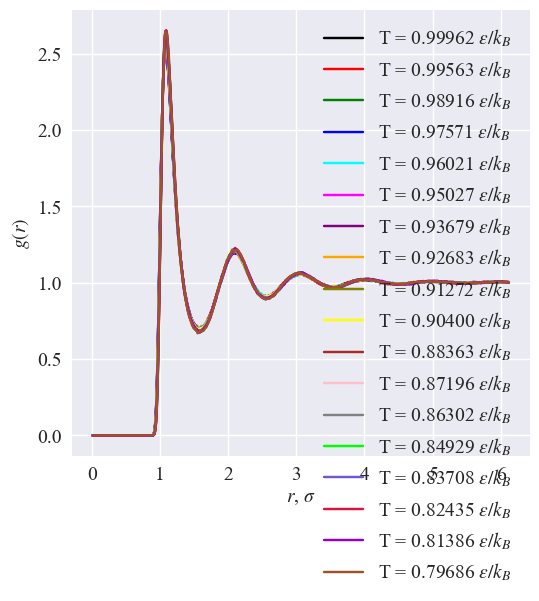

In [10]:
plt.rcParams['font.size'] = 14
for i, temperature in enumerate(temperatures):
    current_rdf = rdf_data[f'{temperature:.5f}']
    plt.plot(
        rdf_data['radius'],
        rdf_data[f'{temperature:.5f}'],
        label=f'T = {temperature:.5f} $\epsilon / k_B $',
        color=colors[i],
    );
    
plt.xlabel('$r$, $\sigma$');
plt.ylabel('$g(r)$');
plt.xlim(
#     left=0.5, 
#     right=1.6,
);
plt.ylim(
#     bottom=2.4, 
#     top=2.6,
);
plt.legend();

save_plot(f'rdf_{plot_filename_postfix}.png')

In [11]:
rdf_points = deepcopy(rdf_data)

rdf_points.index = rdf_points['radius']
rdf_points = rdf_points.drop(columns=['radius'])
rdf_points = rdf_points.T[::-1]
rdf_points

radius,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.10,...,6.03,6.04,6.05,6.06,6.07,6.08,6.09,6.10,6.11,6.12
0.79686,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.005076,1.004279,1.006004,1.005825,1.006622,1.006204,1.005157,1.004797,1.004453,1.003614
0.81386,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.008596,1.006727,1.006849,1.006694,1.007623,1.006596,1.005243,1.005512,1.004371,1.001300
0.82435,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.005256,1.004343,1.006771,1.005670,1.003683,1.002669,1.003794,1.001743,1.002365,1.003717
0.83708,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.002858,1.003487,1.002639,1.002294,1.001504,1.002489,1.003906,1.004377,1.002273,1.002142
0.84929,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.006457,1.004896,1.005194,1.004209,1.003012,1.003053,1.003259,1.002286,1.002260,1.001005
0.86302,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.004181,1.003950,1.002760,1.002391,1.001804,1.001673,1.001064,1.003435,1.004132,1.004688
0.87196,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.002390,1.002349,1.001924,1.002703,1.001301,1.001699,1.001463,0.999682,1.001888,1.001817
0.88363,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.002367,1.002520,1.002548,1.001484,1.002983,1.002836,1.002390,1.002135,1.002676,1.001236
0.90400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.001849,1.004608,1.003384,1.002330,1.003507,1.005792,1.004912,1.004076,1.001845,1.003170
0.91272,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.004706,1.004157,1.003283,1.001744,1.004049,1.002987,1.005154,1.003428,1.002232,1.002725


In [12]:
start = datetime.now()

predicted_points = {key: [] for key in (0.6, 0.5, 0.4, 0.3, 0.2, 0.1)}

for column in rdf_points.columns:
    if (rdf_points[column] == 0).sum() / rdf_points.shape[0] <= 0.5:
        x = rdf_points.index.values.astype(np.float32)
        y = rdf_points[column]
        regr = LinearRegression()
        regr.fit(x.reshape((x.size, 1)), y)
        k = regr.coef_[0]
        b = regr.intercept_
        training_data = k * x + b
        for key, _ in predicted_points.items():
            predicted_points[key].append(k * key + b)
        
#         fig, ax = plt.subplots(figsize=(10, 5))
#         ax.scatter(x, y, label=fr'r = {column}')
#         ax.plot(x, y, label=fr'r = {column}')
#         ax.plot(x, training_data, label=f'{k:.5f} * x + {b:.5f} (MSE = {mean_squared_error(y, training_data)})')
#         plt.legend()
#         plt.show()
    else:
        for key, _ in predicted_points.items():
            predicted_points[key].append(0.0)
        
print(datetime.now() - start)

for key, value in predicted_points.items():
    predicted_points[key] = np.array(value)

0:00:00.476746


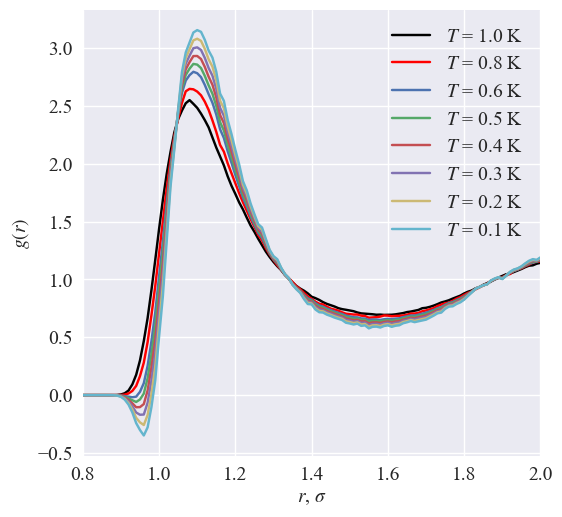

In [13]:
for i, temperature in enumerate((temperatures[0], temperatures[-1])):
    current_rdf = rdf_data[f'{temperature:.5f}']
    plt.plot(
        rdf_data['radius'],
        rdf_data[f'{temperature:.5f}'],
        label=fr'$T$ = {temperature:.1f} K',
        color=colors[i],
    );
for key, value in predicted_points.items():
    plt.plot(rdf_points.columns.values, value, label=fr'$T$ = {key} K');
plt.xlabel('$r$, $\sigma$');
plt.ylabel('$g(r)$');
plt.xlim(
    left=0.8, 
    right=2,
);
plt.ylim(
#     bottom=-0.2, 
#     top=3.5,
);
plt.legend();

#### Временная зависимость среднеквадратичного смещения $\left<\Delta r^2(t)\right>$ при различных температурах

$$\left<\Delta r^2(t)\right>=\dfrac{1}{N}\sum_{i=1}^{N}{\left|\textbf{r}_i(t)-\textbf{r}_i(0)\right|^2}$$

In [14]:
for i, temperature in enumerate(temperatures):
    plt.plot(
        msd_data['time'],
        msd_data[f'{temperature:.5f}'], 
#         label=f'T = {temperature:.1f} $\epsilon / k_B $',
        label=fr'$\Delta t$ = {isotherm_times[i]:.1f}$\tau$',
        color=colors[i],
    );
    
plt.xlabel(r'$t$, $\tau $');
plt.ylabel(r'$\left<\Delta r^2(t)\right>$, $\sigma^2$');
plt.xlim(
    left=0, 
    right=5,
);
plt.ylim(
#     bottom=0, 
#     top=7,
);
plt.legend();

save_plot(f'msd_{plot_filename_postfix}.png')

NameError: name 'isotherm_times' is not defined

#### Временная зависимость автокорреляционнной функции скорости $\Psi(t)$ при различных температурах

$$\Psi(t) = \dfrac{1}{N}\left<\sum_{j=1}^N{\vec{v}_j(t)\vec{v}_j(0)}\right>$$

In [ ]:
for i, temperature in enumerate(temperatures):
    plt.plot(
        vel_autocor_data['time'],
        vel_autocor_data[f'{temperature:.5f}'], 
#         label=f'T = {temperature:.1f} $\epsilon / k_B $',
        label=fr'$\Delta t$ = {isotherm_times[i]:.1f}$\tau$',
        color=colors[i],
    );
    
plt.xlabel(r'$t$, $\tau $');
plt.ylabel(r'$\Psi(t)$, $\sigma^2$');
plt.xlim(
    left=0, 
    right=1,
);
plt.ylim(
#     bottom=0, 
#     top=20,
);
plt.legend();

save_plot(f'vel_autocorr_{plot_filename_postfix}.png')

#### Временная зависимость коэффициента самодиффузии $D$, вычисленного через соотношение Эйнштейна, при различных температурах

$$D_E(t)=\dfrac{\left<\left<\Delta r^2\right>\right>}{6t}=\dfrac{1}{6tN}\left<\sum_{i=1}^{N}\left|\textbf{r}_i(t)-\textbf{r}_i(0)\right|^2\right>$$

$$D=\lim_{t\rightarrow\infty}{D_E(t)}$$

In [ ]:
einstein_diffusion = np.zeros(len(temperatures), dtype=np.float)
green_kubo_diffusion = np.zeros(len(temperatures), dtype=np.float)

In [ ]:
for i, temperature in enumerate(temperatures):
    diff_data = einstein_diffusion_data[f'{temperature:.5f}'].values
    plt.plot(
        einstein_diffusion_data['time'].values,
        diff_data, 
        label=fr'$\Delta t$ = {isotherm_times[i]:.1f}$\tau$',
        color=colors[i],
    );
    einstein_diffusion[i] = diff_data[-1]
    
plt.xlabel(r'$t$, $\tau$');
plt.ylabel(r'$D_E(t)$, $\sigma^2 / \tau$');
plt.xlim(
    left=0, 
    right=8,
);
plt.ylim(
#     bottom=0, 
#     top=0.25,
);
plt.legend();

save_plot(f'diffusion_einstein_{plot_filename_postfix}.png')

#### Временная зависимость коэффициента самодиффузии $D$, вычисленного через соотношение Грина-Кубо, при различных температурах

$$D_{GK}(t)=\dfrac{1}{3}\int_{0}^{t}{\Psi(\tau)d\tau}=\dfrac{1}{3N}\int_{0}^{t}{\left<\sum_{j=1}^N{\vec{v}_j(\tau)\vec{v}_j(0)}\right>d\tau}$$

$$D=\lim_{t\rightarrow\infty}{D_{GK}(t)}$$

In [ ]:
for i, temperature in enumerate(temperatures):
    diff_data = green_kubo_diffusion_data[f'{temperature:.5f}'].values
    plt.plot(
        green_kubo_diffusion_data['time'].values,
        diff_data, 
        label=fr'$\Delta t$ = {isotherm_times[i]:.1f}$\tau$',
        color=colors[i],
    );
    green_kubo_diffusion[i] = diff_data[-1]
    
plt.xlabel(r'$t$, $\tau$');
plt.ylabel(r'$D_{GK}(t)$, $\sigma^2 / \tau$');
plt.xlim(
    left=0, 
    right=8,
);
plt.ylim(
#     bottom=0, 
#     top=0.27,
);
plt.legend();

save_plot(f'diffusion_green_kubo_{plot_filename_postfix}.png')

#### Сравнение коэффициентов самодиффузии, вычисленных через соотношения Эйнштейна и Грина-Кубо

In [ ]:
plt.scatter(
    isotherm_times,
    einstein_diffusion, 
    label='Einstein relation',
);
plt.scatter(
    isotherm_times,
    green_kubo_diffusion, 
    label='Green-Kubo relation',
); 
plt.xlabel(r'$\Delta t$, $\tau$');
plt.ylabel(r'$D$, $\sigma^2 / \tau$');
plt.xlim(
    left=0, 
    right=20,
);
plt.ylim(
    bottom=0, 
    top=0.25,
);
plt.legend(markerscale=1);


save_plot(f'diffusion_comparing_{plot_filename_postfix}.png')

#### Извлечение параметров системы из файла

In [ ]:
system_parameters = pd.read_csv(parameters_filename, sep=';')

for column in system_parameters.columns:
    system_parameters[column] = system_parameters[column].round(5)

system_parameters

In [ ]:
times = (system_parameters.index + 1) * 0.005

#### Зависимость температуры системы от времени

In [ ]:
plt.scatter(
    times,
    system_parameters['temperature'],
    s=1,
);
plt.xlabel(r'$t$, $\tau$');
plt.ylabel(r'Temperature, $\epsilon / k_B$');

plt.xlim(
    left=0,
    right=25,
);
plt.ylim(
#     bottom=2.75,
#     top=5,
);

save_plot(f'temperature_{plot_filename_postfix}.png')

#### Зависимость давления системы от времени

In [ ]:
plt.scatter(
    times,
    system_parameters['pressure'],
    s=1,
);
plt.xlabel(r'$t$, $\tau$');
plt.ylabel(r'Pressure, $\epsilon / \sigma^3 $');

plt.xlim(
    left=0,
    right=25,
);
plt.ylim(
#     bottom=0,
#     top=25,
);
save_plot(f'pressure_{plot_filename_postfix}.png')

#### Зависимость кинетической энергии системы от времени

In [ ]:
plt.scatter(
    times,
    system_parameters['system_kinetic_energy'],
    s=1,
);
plt.xlabel(r'$t$, $\tau$');
plt.ylabel(r'Kinetic Energy, $\epsilon$');

plt.xlim(
    left=0,
    right=25,
);
plt.ylim(
#     bottom=-5000,
#     top=20000,
);
save_plot(f'kinetic_energy_{plot_filename_postfix}.png')

#### Зависимость потенциальной энергии системы от времени

In [ ]:
plt.scatter(
    times,
    system_parameters['potential_energy'],
    s=1,
);
plt.xlabel(r'$t$, $\tau$');
plt.ylabel(r'Potential Energy, $\epsilon$');

plt.xlim(
    left=0,
    right=25,
);
plt.ylim(
#     bottom=-5000,
#     top=20000,
);
save_plot(f'potential_energy_{plot_filename_postfix}.png')

#### Зависимость полной энергии системы от времени

In [ ]:
plt.scatter(
    times,
    system_parameters['total_energy'],
    s=1,
);
plt.xlabel(r'$t$, $\tau$');
plt.ylabel(r'Total Energy, $\epsilon$');

plt.xlim(
    left=0,
    right=25,
);
plt.ylim(
#     bottom=-5000,
#     top=20000,
);
save_plot(f'total_energy_{plot_filename_postfix}.png')

#### Энергии на одном графике

In [ ]:
plt.scatter(
    times,
    system_parameters['system_kinetic_energy'],
    s=1,
    label='Kinetic Energy',
);
plt.scatter(
    times,
    system_parameters['potential_energy'],
    s=1,
    label='Potential Energy',
);
plt.scatter(
    times,
    system_parameters['total_energy'],
    s=1,
    label='Total Energy',
);

plt.xlabel(r'$t$, $\tau$');
plt.ylabel(r'Energy, $\epsilon$');
plt.legend(markerscale=5);

plt.xlim(
    left=0,
    right=25,
);
plt.ylim(
#     bottom=-10000,
#     top=6000,
);
save_plot(f'all_energies_{plot_filename_postfix}.png')